# Exploration and Comparison of Transformers for Image Classification

## Linear Probing using Swin Transformer (Swin)

Linear probing is an experiment that involves training a linear classifier on top of pre-trained frozen features of the model.

In this experiment, the whole training set is used.

### Swin Transformer (Swin)

Swin Transformer model trained on ImageNet-1k at resolution 224x224. It was introduced in the paper *Swin Transformer: Hierarchical Vision Transformer using Shifted Windows by Liu et al.*

https://arxiv.org/abs/2103.14030

### Prerequisites

Load necessary packages.

In [2]:
import os
os.chdir('../../../')

import torch

import pandas as pd

from datasets import load_dataset

from src.dataset_builder import ImageDataset
from src.models import *
from src.train import *

from utils.config import Config
from utils.train_utils import *
from utils.models_utils import *
from utils.visualization_utils import *
from utils.data_utils import *

Check if there is GPU available.

In [2]:
get_gpu_info()

GPU 0: NVIDIA A100 80GB PCIe MIG 2g.20gb
VRAM: 19.50 GB


Set manual seed for reproducibility.

In [3]:
id = 10
torch.manual_seed(10)

Load Swin image processor used for image pre-processing.

In [4]:
processor = get_backbone_processor(model_names['Swin'])

Print the pre-processing operations done by the processor.

In [5]:
processor

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

### Data Preprocessing

Load each dataset and its splits.

Processor is automatically applied to each image.

#### RESISC45

In [7]:
resisc45 = load_dataset('timm/resisc45')
clean_labels(resisc45, name='resisc45')
resisc45_train = ImageDataset(
    dataset=resisc45['train'],
    processor=processor,
)
resisc45_validation = ImageDataset(
    dataset=resisc45['validation'],
    processor=processor,
)
resisc45_test = ImageDataset(
    dataset=resisc45['test'],
    processor=processor,
)

#### Food-101

In [9]:
food101 = load_dataset('ethz/food101')
clean_labels(food101, name='food101')
food101_train = ImageDataset(
    dataset=food101['train'],
    processor=processor,
)
food101_validation = ImageDataset(
    dataset=food101['validation'],
    processor=processor,
)

#### FER2013

In [11]:
fer2013 = load_dataset('AutumnQiu/fer2013')
clean_labels(fer2013, name='fer2013')
fer2013_train = ImageDataset(
    dataset=fer2013['train'],
    processor=processor,
)
fer2013_validation = ImageDataset(
    dataset=fer2013['valid'],
    processor=processor,
)
fer2013_test = ImageDataset(
    dataset=fer2013['test'],
    processor=processor,
)

#### PCam

In [13]:
pcam = load_dataset('zacharielegault/PatchCamelyon')
clean_labels(pcam, name='pcam')
pcam_train = ImageDataset(
    dataset=pcam['train'],
    processor=processor,
)
pcam_validation = ImageDataset(
    dataset=pcam['validation'],
    processor=processor,
)
pcam_test = ImageDataset(
    dataset=pcam['test'],
    processor=processor,
)

#### SUN397

In [15]:
sun397 = load_dataset('dpdl-benchmark/sun397')
clean_labels(sun397, name='sun397')
sun397_train = ImageDataset(
    dataset=sun397['train'],
    processor=processor,
)
sun397_validation = ImageDataset(
    dataset=sun397['validation'],
    processor=processor,
)
sun397_test = ImageDataset(
    dataset=sun397['test'],
    processor=processor,
)

Resolving data files:   0%|          | 0/28 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/28 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/28 [00:00<?, ?it/s]

#### DTD

In [17]:
dtd = load_dataset('tanganke/dtd')
clean_labels(dtd, name='dtd')
dtd_train = ImageDataset(
    dataset=dtd['train'],
    processor=processor,
)
dtd_test = ImageDataset(
    dataset=dtd['test'],
    processor=processor,
)

### Config

Create a config for the experiments and print its settings.

In [3]:
from torch.optim import AdamW

config = Config(
    num_epochs=10, 
    lr=1e-4,
    optimizer=AdamW,
    weight_decay=0
)
config.get_settings()

{'device': 'cuda',
 'criterion': CrossEntropyLoss(),
 'batch_size': 8,
 'lr': 0.0001,
 'num_epochs': 10,
 'optimizer': torch.optim.adamw.AdamW,
 'weight_decay': 0,
 'dropout_rate': 0.1,
 'early_stopping': {'enabled': False, 'patience': 3, 'delta': 0},
 'gradient_clipping': {'enabled': False, 'max_norm': 0},
 'scheduler': {'enabled': False,
  'warmup_epochs': 0,
  'eta_min': 0,
  'linear_start_factor': 0.1,
  'linear_end_factor': 1.0}}

Create empty arrays to store accuracies for each dataset.

In [19]:
resisc45_accs = []
food101_accs = []
fer2013_accs = []
pcam_accs = []
sun397_accs = []
dtd_accs = []

### Linear Probing


Train a new linear classifier on top of the pre-trained frozen model base.

#### RESISC45

In [20]:
swin_resisc45 = Backbone(model_names['Swin'], num_classes=len(resisc45_train.get_labels()))

Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-base-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([45]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([45, 1024]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
get_model_params(swin_resisc45)

Parameters: 86.79M


In [22]:
resisc45_loss, resisc45_acc, resisc45_per_class_acc = train_model(
    swin_resisc45,
    resisc45_train,
    config,
    'swin',
    use_val=False,
    fine_tune=False,
)

100%|██████████| 2363/2363 [04:01<00:00,  9.78it/s]


Epochs: 1/10 | train_loss: 1.6352 | train_acc: 0.6690


100%|██████████| 2363/2363 [03:59<00:00,  9.86it/s]


Epochs: 2/10 | train_loss: 0.7471 | train_acc: 0.8185


100%|██████████| 2363/2363 [04:00<00:00,  9.83it/s]


Epochs: 3/10 | train_loss: 0.5813 | train_acc: 0.8474


100%|██████████| 2363/2363 [04:00<00:00,  9.84it/s]


Epochs: 4/10 | train_loss: 0.4964 | train_acc: 0.8679


100%|██████████| 2363/2363 [04:00<00:00,  9.84it/s]


Epochs: 5/10 | train_loss: 0.4417 | train_acc: 0.8794


100%|██████████| 2363/2363 [04:01<00:00,  9.79it/s]


Epochs: 6/10 | train_loss: 0.4042 | train_acc: 0.8878


100%|██████████| 2363/2363 [04:02<00:00,  9.76it/s]


Epochs: 7/10 | train_loss: 0.3740 | train_acc: 0.8937


100%|██████████| 2363/2363 [04:02<00:00,  9.73it/s]


Epochs: 8/10 | train_loss: 0.3510 | train_acc: 0.9015


100%|██████████| 2363/2363 [04:00<00:00,  9.84it/s]


Epochs: 9/10 | train_loss: 0.3324 | train_acc: 0.9060


100%|██████████| 2363/2363 [04:01<00:00,  9.79it/s]

Epochs: 10/10 | train_loss: 0.3145 | train_acc: 0.9095


In [23]:
resisc45_loss, resisc45_acc, resisc45_per_class_acc = evaluate_model(
    swin_resisc45,
    resisc45_test,
    config
)

100%|██████████| 788/788 [01:19<00:00,  9.85it/s]

test_loss: 0.3677 | test_acc: 0.8854


In [24]:
resisc45_accs.append(resisc45_acc)

In [25]:
get_top_5_accuracies(resisc45_per_class_acc)

[('snowberg', 0.9748427672955975),
 ('sea ice', 0.9735099337748344),
 ('circular farmland', 0.9726027397260274),
 ('airplane', 0.9704142011834319),
 ('ship', 0.9703703703703703)]

In [26]:
get_bottom_5_accuracies(resisc45_per_class_acc)

[('palace', 0.6214285714285714),
 ('basketball court', 0.6716417910447762),
 ('intersection', 0.7538461538461538),
 ('commercial area', 0.7571428571428571),
 ('tennis court', 0.7708333333333334)]

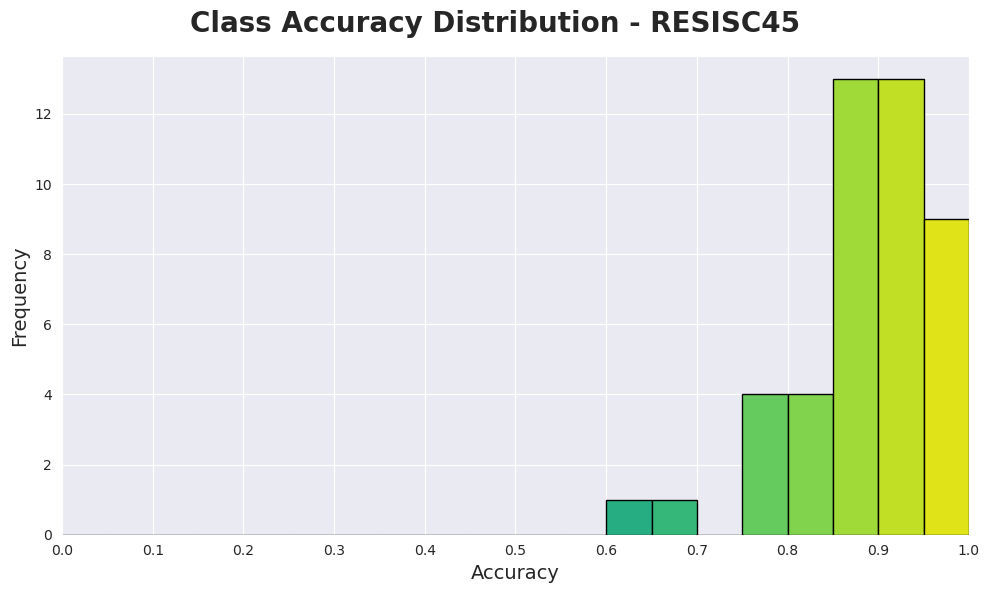

In [27]:
plot_per_class_accuracies(
    resisc45_per_class_acc,
    'RESISC45',
    num_bins=20
)

#### Food-101

In [28]:
swin_food101 = Backbone(model_names['Swin'], num_classes=len(food101_train.get_labels()))

Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-base-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([101]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([101, 1024]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [29]:
get_model_params(swin_food101)

Parameters: 86.85M


In [30]:
food101_loss, food101_acc, food101_per_class_acc = train_model(
    swin_food101,
    food101_train,
    config,
    'swin',
    use_val=False,
    fine_tune=False,
)

 73%|███████▎  | 6955/9469 [13:40<04:59,  8.39it/s]/opt/conda/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))
100%|██████████| 9469/9469 [18:34<00:00,  8.49it/s]


Epochs: 1/10 | train_loss: 1.2591 | train_acc: 0.7394


100%|██████████| 9469/9469 [18:30<00:00,  8.52it/s]


Epochs: 2/10 | train_loss: 0.6756 | train_acc: 0.8215


100%|██████████| 9469/9469 [18:29<00:00,  8.53it/s]


Epochs: 3/10 | train_loss: 0.5943 | train_acc: 0.8406


100%|██████████| 9469/9469 [18:30<00:00,  8.52it/s]


Epochs: 4/10 | train_loss: 0.5494 | train_acc: 0.8523


100%|██████████| 9469/9469 [18:30<00:00,  8.53it/s]


Epochs: 5/10 | train_loss: 0.5183 | train_acc: 0.8604


100%|██████████| 9469/9469 [18:31<00:00,  8.52it/s]


Epochs: 6/10 | train_loss: 0.4916 | train_acc: 0.8661


100%|██████████| 9469/9469 [18:31<00:00,  8.52it/s]


Epochs: 7/10 | train_loss: 0.4717 | train_acc: 0.8722


100%|██████████| 9469/9469 [18:29<00:00,  8.53it/s]


Epochs: 8/10 | train_loss: 0.4554 | train_acc: 0.8761


100%|██████████| 9469/9469 [18:29<00:00,  8.53it/s]


Epochs: 9/10 | train_loss: 0.4411 | train_acc: 0.8792


100%|██████████| 9469/9469 [18:29<00:00,  8.53it/s]


Epochs: 10/10 | train_loss: 0.4288 | train_acc: 0.8829


In [31]:
food101_loss, food101_acc, food101_per_class_acc = evaluate_model(
    swin_food101,
    food101_validation,
    config
)

100%|██████████| 3157/3157 [06:07<00:00,  8.60it/s]


test_loss: 0.3689 | test_acc: 0.8947


In [32]:
food101_accs.append(food101_acc)

In [33]:
get_top_5_accuracies(food101_per_class_acc)

[('edamame', 0.992),
 ('guacamole', 0.992),
 ('oysters', 0.988),
 ('macarons', 0.972),
 ('spaghetti carbonara', 0.972)]

In [34]:
get_bottom_5_accuracies(food101_per_class_acc)

[('steak', 0.416),
 ('pork chop', 0.696),
 ('cheesecake', 0.708),
 ('foie gras', 0.728),
 ('apple pie', 0.744)]

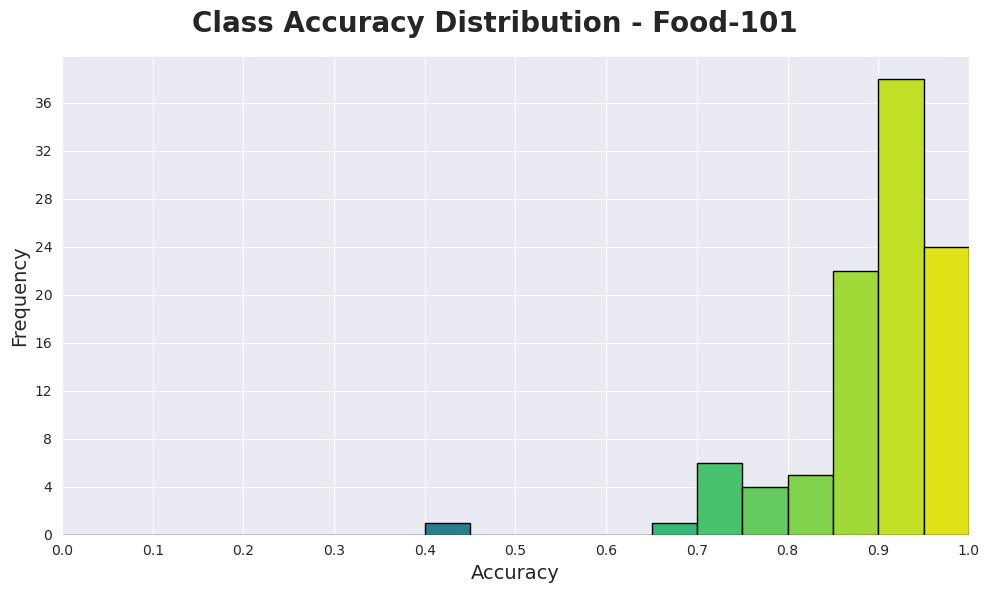

In [35]:
plot_per_class_accuracies(
    food101_per_class_acc,
    'Food-101',
    num_bins=20
)

#### FER2013

In [36]:
swin_fer2013 = Backbone(model_names['Swin'], num_classes=len(fer2013_train.get_labels()))

Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-base-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([7, 1024]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [37]:
get_model_params(swin_fer2013)

Parameters: 86.75M


In [38]:
fer2013_loss, fer2013_acc, fer2013_per_class_acc = train_model(
    swin_fer2013,
    fer2013_train,
    config,
    'swin',
    use_val=False,
    fine_tune=False,
)

100%|██████████| 3589/3589 [05:43<00:00, 10.46it/s]


Epochs: 1/10 | train_loss: 1.2934 | train_acc: 0.5199


100%|██████████| 3589/3589 [05:43<00:00, 10.46it/s]


Epochs: 2/10 | train_loss: 1.1601 | train_acc: 0.5715


100%|██████████| 3589/3589 [05:42<00:00, 10.48it/s]


Epochs: 3/10 | train_loss: 1.1272 | train_acc: 0.5803


100%|██████████| 3589/3589 [05:42<00:00, 10.48it/s]


Epochs: 4/10 | train_loss: 1.1058 | train_acc: 0.5880


100%|██████████| 3589/3589 [05:42<00:00, 10.49it/s]


Epochs: 5/10 | train_loss: 1.0882 | train_acc: 0.5969


100%|██████████| 3589/3589 [05:42<00:00, 10.48it/s]


Epochs: 6/10 | train_loss: 1.0770 | train_acc: 0.6006


100%|██████████| 3589/3589 [05:43<00:00, 10.46it/s]


Epochs: 7/10 | train_loss: 1.0663 | train_acc: 0.6025


100%|██████████| 3589/3589 [05:41<00:00, 10.50it/s]


Epochs: 8/10 | train_loss: 1.0594 | train_acc: 0.6049


100%|██████████| 3589/3589 [05:43<00:00, 10.46it/s]


Epochs: 9/10 | train_loss: 1.0523 | train_acc: 0.6075


100%|██████████| 3589/3589 [05:42<00:00, 10.47it/s]

Epochs: 10/10 | train_loss: 1.0474 | train_acc: 0.6125


In [39]:
fer2013_loss, fer2013_acc, fer2013_per_class_acc = evaluate_model(
    swin_fer2013,
    fer2013_test,
    config
)

100%|██████████| 449/449 [00:42<00:00, 10.60it/s]

test_loss: 1.0380 | test_acc: 0.6121


In [40]:
fer2013_accs.append(fer2013_acc)

In [41]:
fer2013_per_class_acc

{'angry': 0.3890020366598778,
 'disgust': 0.18181818181818182,
 'fear': 0.2935606060606061,
 'happy': 0.8680318543799772,
 'sad': 0.5892255892255892,
 'surprise': 0.7427884615384616,
 'neutral': 0.6693290734824281}

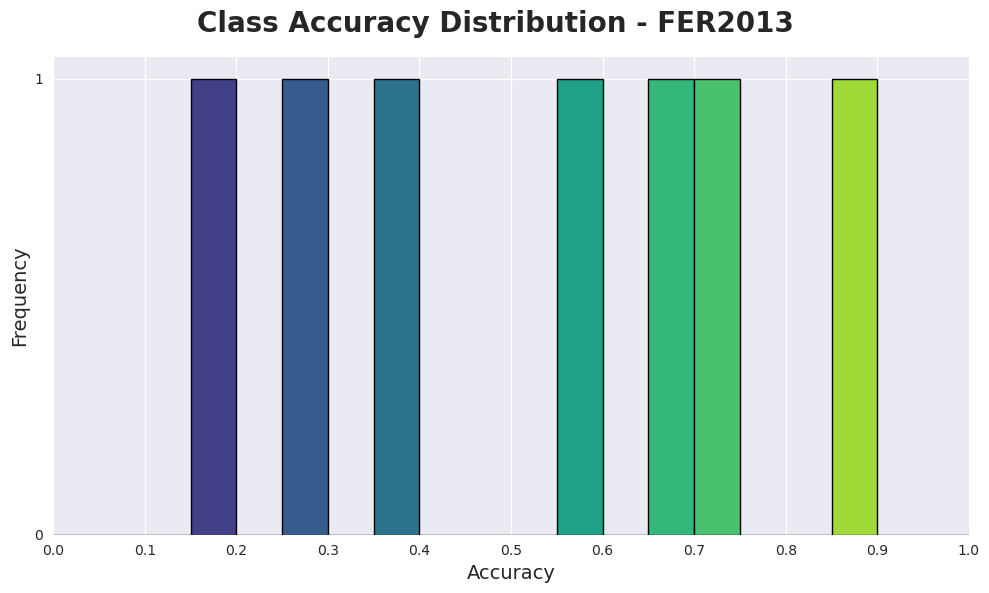

In [42]:
plot_per_class_accuracies(
    fer2013_per_class_acc,
    'FER2013',
    num_bins=20
)

#### PCam

In [43]:
swin_pcam = Backbone(model_names['Swin'], num_classes=len(pcam_train.get_labels()))

Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-base-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([2, 1024]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [44]:
get_model_params(swin_pcam)

Parameters: 86.75M


In [45]:
pcam_loss, pcam_acc, pcam_per_class_acc = train_model(
    swin_pcam,
    pcam_train,
    config,
    'swin',
    use_val=False,
    fine_tune=False,
)

100%|██████████| 32768/32768 [52:48<00:00, 10.34it/s]


Epochs: 1/10 | train_loss: 0.3070 | train_acc: 0.8690


100%|██████████| 32768/32768 [52:47<00:00, 10.34it/s]


Epochs: 2/10 | train_loss: 0.2755 | train_acc: 0.8856


100%|██████████| 32768/32768 [52:46<00:00, 10.35it/s]


Epochs: 3/10 | train_loss: 0.2683 | train_acc: 0.8886


100%|██████████| 32768/32768 [52:46<00:00, 10.35it/s]


Epochs: 4/10 | train_loss: 0.2642 | train_acc: 0.8914


100%|██████████| 32768/32768 [52:45<00:00, 10.35it/s]


Epochs: 5/10 | train_loss: 0.2614 | train_acc: 0.8927


100%|██████████| 32768/32768 [52:43<00:00, 10.36it/s]


Epochs: 6/10 | train_loss: 0.2589 | train_acc: 0.8938


100%|██████████| 32768/32768 [52:43<00:00, 10.36it/s]


Epochs: 7/10 | train_loss: 0.2577 | train_acc: 0.8943


100%|██████████| 32768/32768 [52:44<00:00, 10.35it/s]


Epochs: 8/10 | train_loss: 0.2569 | train_acc: 0.8946


100%|██████████| 32768/32768 [52:45<00:00, 10.35it/s]


Epochs: 9/10 | train_loss: 0.2560 | train_acc: 0.8954


100%|██████████| 32768/32768 [52:49<00:00, 10.34it/s]

Epochs: 10/10 | train_loss: 0.2567 | train_acc: 0.8953


In [46]:
pcam_loss, pcam_acc, pcam_per_class_acc = evaluate_model(
    swin_pcam,
    pcam_test,
    config
)

100%|██████████| 4096/4096 [06:31<00:00, 10.45it/s]

test_loss: 0.3568 | test_acc: 0.8456


In [47]:
pcam_accs.append(pcam_acc)

In [48]:
pcam_per_class_acc

{'healthy lymph node tissue': 0.9158684644011957,
 'lymph node tumor tissue': 0.7751724980155096}

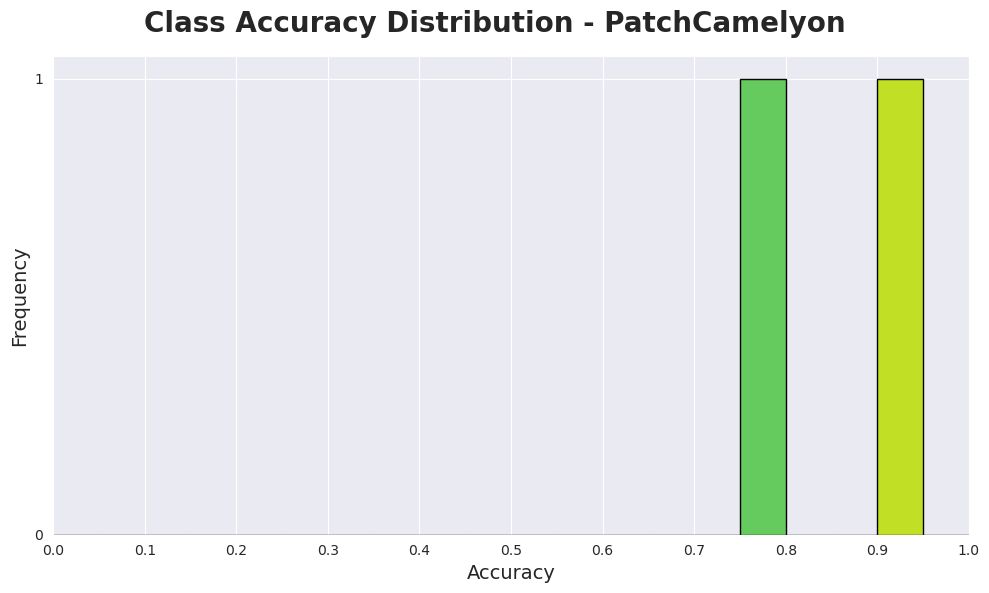

In [49]:
plot_per_class_accuracies(
    pcam_per_class_acc,
    'PatchCamelyon',
    num_bins=20
)

#### SUN397

In [50]:
swin_sun397 = Backbone(model_names['Swin'], num_classes=len(sun397_train.get_labels()))

Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-base-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([397]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([397, 1024]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [51]:
get_model_params(swin_sun397)

Parameters: 87.15M


In [52]:
sun397_loss, sun397_acc, sun397_per_class_acc = train_model(
    swin_sun397,
    sun397_train,
    config,
    'swin',
    use_val=False,
    fine_tune=False,
)

100%|██████████| 9516/9516 [19:41<00:00,  8.05it/s]


Epochs: 1/10 | train_loss: 1.7223 | train_acc: 0.6641


100%|██████████| 9516/9516 [19:13<00:00,  8.25it/s]


Epochs: 2/10 | train_loss: 0.7250 | train_acc: 0.7964


100%|██████████| 9516/9516 [19:13<00:00,  8.25it/s]


Epochs: 3/10 | train_loss: 0.6100 | train_acc: 0.8223


100%|██████████| 9516/9516 [19:13<00:00,  8.25it/s]


Epochs: 4/10 | train_loss: 0.5436 | train_acc: 0.8407


100%|██████████| 9516/9516 [19:14<00:00,  8.25it/s]


Epochs: 5/10 | train_loss: 0.4943 | train_acc: 0.8535


100%|██████████| 9516/9516 [19:12<00:00,  8.26it/s]


Epochs: 6/10 | train_loss: 0.4547 | train_acc: 0.8652


100%|██████████| 9516/9516 [19:12<00:00,  8.26it/s]


Epochs: 7/10 | train_loss: 0.4228 | train_acc: 0.8763


100%|██████████| 9516/9516 [19:14<00:00,  8.24it/s]


Epochs: 8/10 | train_loss: 0.3959 | train_acc: 0.8831


100%|██████████| 9516/9516 [19:14<00:00,  8.24it/s]


Epochs: 9/10 | train_loss: 0.3725 | train_acc: 0.8906


100%|██████████| 9516/9516 [19:14<00:00,  8.25it/s]


Epochs: 10/10 | train_loss: 0.3535 | train_acc: 0.8964


In [53]:
sun397_loss, sun397_acc, sun397_per_class_acc = evaluate_model(
    swin_sun397,
    sun397_test,
    config
)

100%|██████████| 2719/2719 [05:28<00:00,  8.27it/s]


test_loss: 0.6736 | test_acc: 0.8042


In [54]:
sun397_accs.append(sun397_acc)

In [55]:
get_top_5_accuracies(sun397_per_class_acc)

[('arrival gate (outdoor)', 1.0),
 ('boxing ring', 1.0),
 ('bullring', 1.0),
 ('dentists office', 1.0),
 ('electrical substation', 1.0)]

In [56]:
get_bottom_5_accuracies(sun397_per_class_acc)

[('library (outdoor)', 0.09523809523809523),
 ('recreation room', 0.1111111111111111),
 ('monastery (outdoor)', 0.1724137931034483),
 ('inn (outdoor)', 0.20689655172413793),
 ('hunting lodge (outdoor)', 0.20833333333333334)]

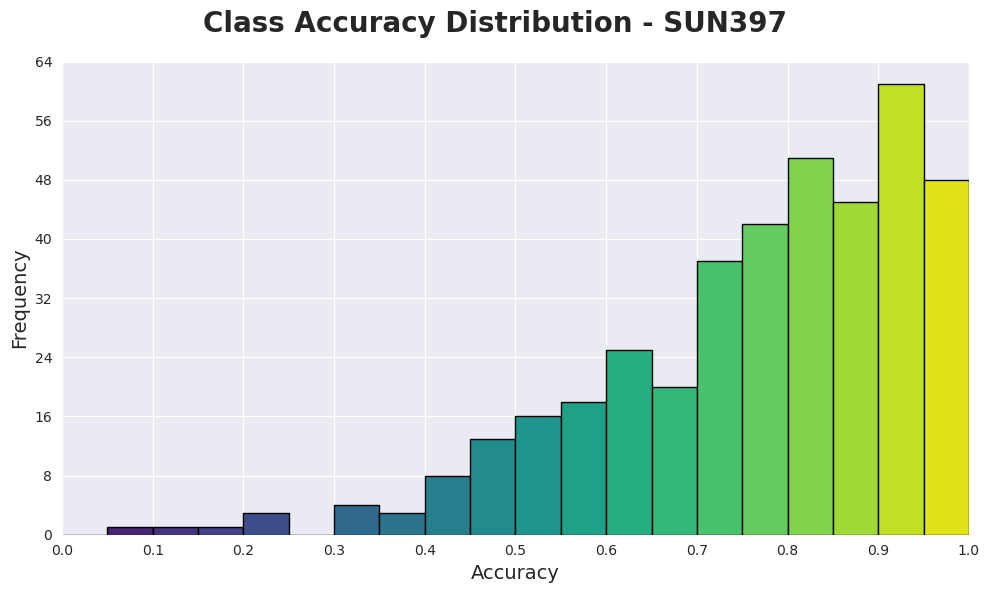

In [57]:
plot_per_class_accuracies(
    sun397_per_class_acc,
    'SUN397',
    num_bins=20
)

#### DTD

In [58]:
swin_dtd = Backbone(model_names['Swin'], num_classes=len(dtd_train.get_labels()))

Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-base-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([47]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([47, 1024]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [59]:
get_model_params(swin_dtd)

Parameters: 86.79M


In [60]:
dtd_loss, dtd_acc, dtd_per_class_acc = train_model(
    swin_dtd,
    dtd_train,
    config,
    'swin',
    use_val=False,
    fine_tune=False,
)

100%|██████████| 470/470 [00:56<00:00,  8.25it/s]


Epochs: 1/10 | train_loss: 3.1738 | train_acc: 0.3604


100%|██████████| 470/470 [00:56<00:00,  8.30it/s]


Epochs: 2/10 | train_loss: 2.0185 | train_acc: 0.6827


100%|██████████| 470/470 [00:56<00:00,  8.25it/s]


Epochs: 3/10 | train_loss: 1.4400 | train_acc: 0.7489


100%|██████████| 470/470 [00:56<00:00,  8.25it/s]


Epochs: 4/10 | train_loss: 1.1408 | train_acc: 0.7814


100%|██████████| 470/470 [00:56<00:00,  8.26it/s]


Epochs: 5/10 | train_loss: 0.9633 | train_acc: 0.8069


100%|██████████| 470/470 [00:57<00:00,  8.21it/s]


Epochs: 6/10 | train_loss: 0.8325 | train_acc: 0.8282


100%|██████████| 470/470 [00:56<00:00,  8.26it/s]


Epochs: 7/10 | train_loss: 0.7395 | train_acc: 0.8434


100%|██████████| 470/470 [00:57<00:00,  8.24it/s]


Epochs: 8/10 | train_loss: 0.6680 | train_acc: 0.8529


100%|██████████| 470/470 [00:56<00:00,  8.27it/s]


Epochs: 9/10 | train_loss: 0.6066 | train_acc: 0.8598


100%|██████████| 470/470 [00:56<00:00,  8.28it/s]

Epochs: 10/10 | train_loss: 0.5528 | train_acc: 0.8803


In [61]:
dtd_loss, dtd_acc, dtd_per_class_acc = evaluate_model(
    swin_dtd,
    dtd_test,
    config
)

100%|██████████| 235/235 [00:27<00:00,  8.44it/s]

test_loss: 0.8229 | test_acc: 0.7824


In [62]:
dtd_accs.append(dtd_acc)

In [63]:
get_top_5_accuracies(dtd_per_class_acc)

[('scaly', 0.975),
 ('studded', 0.975),
 ('bubbly', 0.95),
 ('crystalline', 0.95),
 ('knitted', 0.95)]

In [64]:
get_bottom_5_accuracies(dtd_per_class_acc)

[('blotchy', 0.425),
 ('stained', 0.475),
 ('woven', 0.475),
 ('porous', 0.55),
 ('pitted', 0.6)]

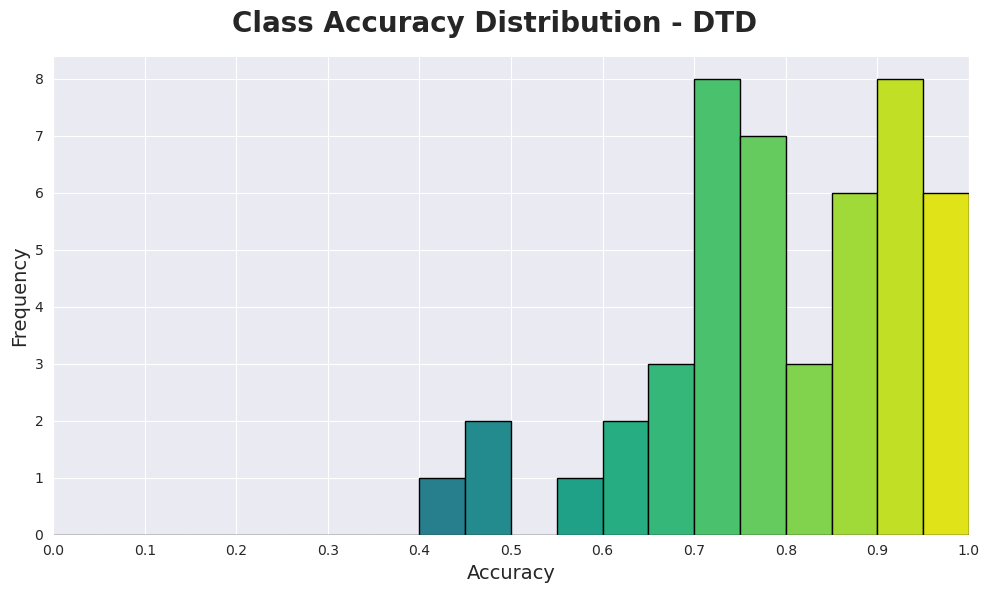

In [65]:
plot_per_class_accuracies(
    dtd_per_class_acc,
    'DTD',
    num_bins=20
)

### Results

Display the results of the analysis in dataframe.

In [66]:
results = [
    resisc45_accs,
    food101_accs,
    fer2013_accs,
    pcam_accs,
    sun397_accs,
    dtd_accs,
]

In [67]:
labels = ['RESISC45', 'Food-101', 'FER2013', 'PatchCamelyon', 'SUN397', 'DTD']

In [68]:
acc_dict = create_accuracy_dict(
    results,
    labels
)

In [69]:
df = pd.DataFrame(results, columns=['linear probe'], index=labels)
df

,linear probe
RESISC45,0.885397
Food-101,0.894733
FER2013,0.612148
PatchCamelyon,0.845551
SUN397,0.804184
DTD,0.782447
